In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as sc
from scipy.stats import norm
from scipy import optimize
from scipy.optimize import minimize
import time
import statsmodels.api as sm

# QQ Plot of STOXX 50

[*********************100%***********************]  1 of 1 completed


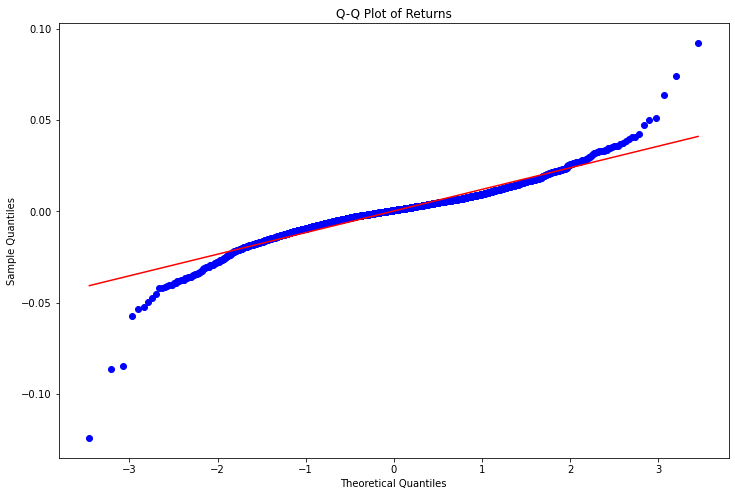

In [3]:
ticker = "^STOXX50E"
sp500 = yf.download(ticker, start="2014-01-01", end="2024-01-01")

sp500['Returns'] = sp500['Adj Close'].pct_change().dropna()

returns = sp500['Returns'].dropna()

plt.figure(figsize=(12, 8))

stats.probplot(returns, dist="norm", plot=plt)
plt.title('Q-Q Plot of Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


# Fractional Brownian motion (fBm) plots

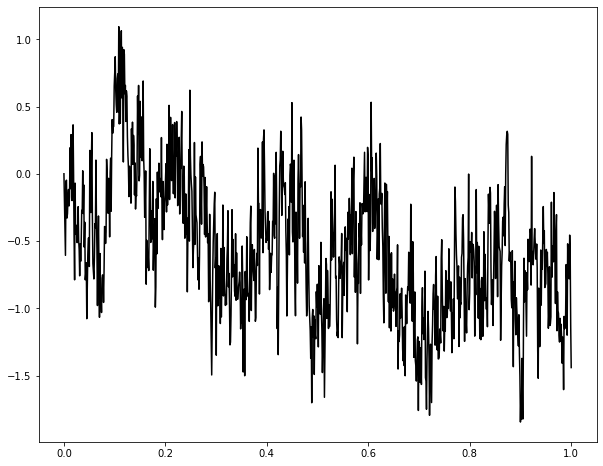

In [4]:
def covariance(s, t, H):
    return 0.5 * (np.power(t, 2 * H) + np.power(s, 2 * H) - np.power(np.abs(t - s), 2 * H))

n_steps = 1000
dt = 1 / n_steps
H = 0.15
t_i = np.linspace(0, 1, n_steps)

cov_matrix = np.zeros((n_steps - 1, n_steps - 1))

for i in range(n_steps - 1):
    for j in range(i + 1):
        cov_matrix[i, j] = covariance(t_i[i + 1], t_i[j + 1], H)
        cov_matrix[j, i] = cov_matrix[i, j]

lower_diag = np.linalg.cholesky(cov_matrix)

fBm = np.zeros(n_steps)
W = np.random.normal(0, 1, size=( n_steps-1 ))
fBm[1:] = np.dot(W, lower_diag.T)

plt.figure(figsize=(10, 8))
plt.plot(t_i, fBm[:].reshape(t_i.shape), color='black')

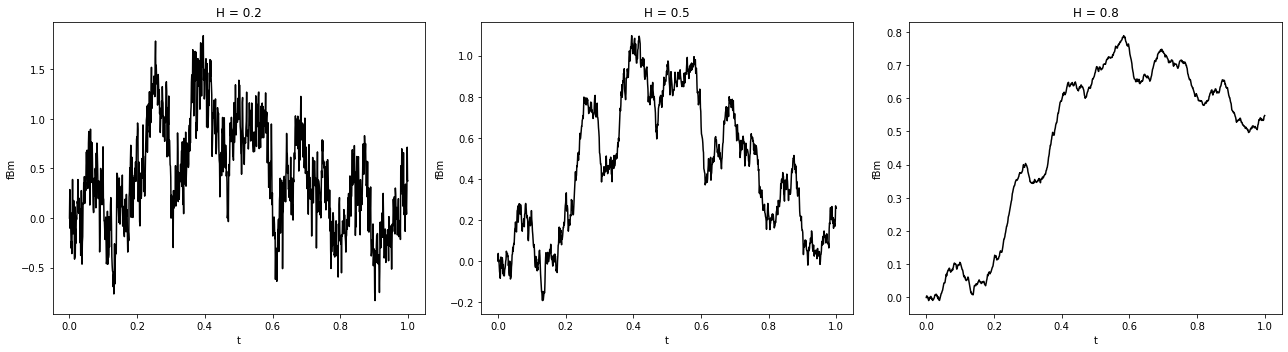

In [5]:
def covariance(s, t, H):
    return 0.5 * (np.power(t, 2 * H) + np.power(s, 2 * H) - np.power(np.abs(t - s), 2 * H))

n_steps = 1000
dt = 1 / n_steps
t_i = np.linspace(0, 1, n_steps)
W = np.random.normal(0, 1, size=(n_steps - 1))
Hs = [0.2, 0.5, 0.8]

plt.figure(figsize=(18, 5))

for idx, H in enumerate(Hs):
    cov_matrix = np.zeros((n_steps - 1, n_steps - 1))
    
    for i in range(n_steps - 1):
        for j in range(i + 1):
            cov_matrix[i, j] = covariance(t_i[i + 1], t_i[j + 1], H)
            cov_matrix[j, i] = cov_matrix[i, j]

    lower_diag = np.linalg.cholesky(cov_matrix)

    fBm = np.zeros(n_steps)
    fBm[1:] = np.dot(W, lower_diag.T)

    plt.subplot(1, 3, idx + 1)
    plt.plot(t_i, fBm[:].reshape(t_i.shape), color='black')
    plt.title(f'H = {H}')
    plt.xlabel('t')
    plt.ylabel('fBm')

plt.tight_layout()
plt.show()


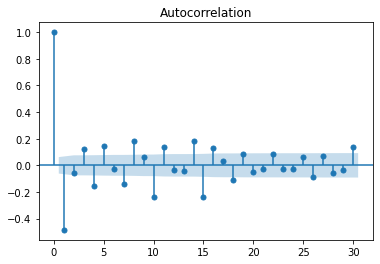

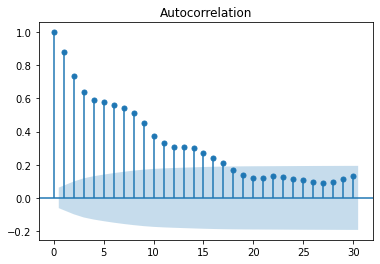

In [11]:
def covariance(s, t, H):
    return 0.5 * (np.power(t, 2 * H) + np.power(s, 2 * H) - np.power(np.abs(t - s), 2 * H))

def autocorrelation(x):
    n = len(x)
    variance = np.var(x)
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[-n:]
    result = r / (variance * (np.arange(n, 0, -1)))
    return result

n_steps = 1000
dt = 1 / n_steps
t_i = np.linspace(0, 1, n_steps)

cov_matrix1 = np.zeros((n_steps - 1, n_steps - 1))
cov_matrix2 = np.zeros((n_steps - 1, n_steps - 1))

for i in range(n_steps - 1):
    for j in range(i + 1):
        cov_matrix1[i, j] = covariance(t_i[i + 1], t_i[j + 1], 0.15)
        cov_matrix1[j, i] = cov_matrix1[i, j]

for i in range(n_steps - 1):
    for j in range(i + 1):
        cov_matrix2[i, j] = covariance(t_i[i + 1], t_i[j + 1], 0.85)
        cov_matrix2[j, i] = cov_matrix2[i, j]


lower_diag1 = np.linalg.cholesky(cov_matrix1)
lower_diag2 = np.linalg.cholesky(cov_matrix2)

fBm1 = np.zeros(n_steps)
fBm2 = np.zeros(n_steps)
W = np.random.normal(0, 1, size=(n_steps - 1))
fBm1[1:] = np.dot(W, lower_diag1.T)
fBm2[1:] = np.dot(W, lower_diag2.T)

increments1 = np.diff(fBm1)
increments2 = np.diff(fBm2)

acf_increments1 = autocorrelation(increments1)
acf_increments2 = autocorrelation(increments2)


fig1 = sm.graphics.tsa.plot_acf(acf_increments1, lags=30)
fig2 = sm.graphics.tsa.plot_acf(acf_increments2, lags=30)


plt.show()


# Riemann-Liouville fBm plots

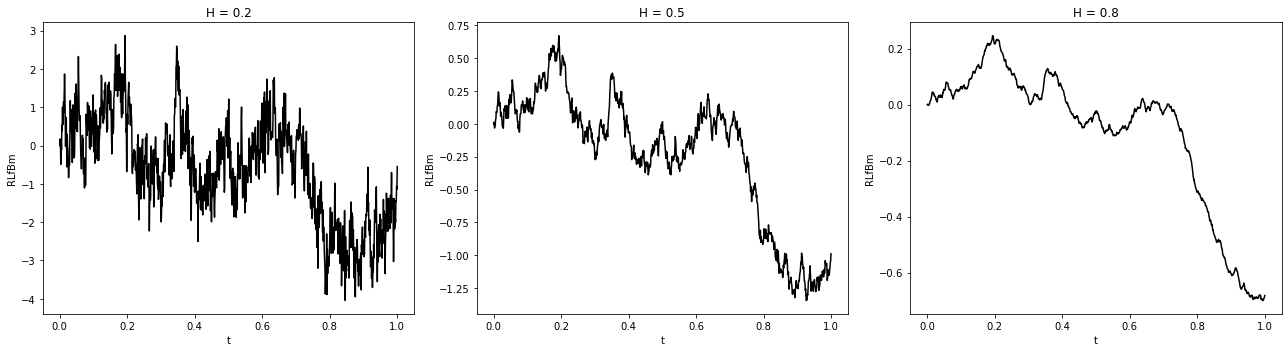

In [12]:
def covariance(s, t, H):
    return np.power(s,(H+0.5))*np.power(t,(H-0.5))*(1/(H+(0.5**2)))*sc.hyp2f1((0.5-H),1,(H+1.5),(s/t))

n_steps = 1000
dt = 1 / n_steps
t_i = np.linspace(0, 1, n_steps)
W = np.random.normal(0, 1, size=(n_steps - 1))  # Same W for all plots
Hs = [0.2, 0.5, 0.8]

plt.figure(figsize=(18, 5))

for idx, H in enumerate(Hs):
    cov_matrix = np.zeros((n_steps - 1, n_steps - 1))
    
    for i in range(0, n_steps - 1):
        for j in range(0, i + 1):
            if j < i:
                cov_matrix[i, j] = covariance(t_i[j + 1], t_i[i + 1], H)
            else:
                cov_matrix[i, j] = covariance(t_i[i + 1], t_i[j + 1], H)
                cov_matrix[j, i] = cov_matrix[i, j]

    lower_diag = np.linalg.cholesky(cov_matrix)

    RLfBm = np.zeros(n_steps)
    RLfBm[1:] = np.dot(W, lower_diag.T)

    plt.subplot(1, 3, idx + 1)
    plt.plot(t_i, RLfBm[:].reshape(t_i.shape), color='black')
    plt.title(f'H = {H}')
    plt.xlabel('t')
    plt.ylabel('RLfBm')

plt.tight_layout()
plt.show()


# Standard Monte Carlo

In [13]:
def covariance(s, t, H):
    return 0.5 * (np.power(t, 2 * H) + np.power(s, 2 * H) - np.power(np.abs(t - s), 2 * H))


n_simulations = 50
n_paths = 1000
n_steps = 1000
dt = 1 / n_steps
H = 0.15
t_i = np.linspace(0, 1, n_steps)
K = 80

cov_matrix = np.zeros((n_steps - 1, n_steps - 1))

for i in range(n_steps - 1):
    for j in range(i + 1):
        cov_matrix[i, j] = covariance(t_i[i + 1], t_i[j + 1], H)
        cov_matrix[j, i] = cov_matrix[i, j]

lower_diag = np.linalg.cholesky(cov_matrix)

nu = 0.4
r = 0.0
S_0 = 100
X_0 = np.log(S_0)
sigma_0 = 0.1


option_prices = []

paths = np.zeros((n_paths, n_steps))
X = np.zeros((n_paths, n_steps))
sigma = np.zeros((n_paths, n_steps))
S = np.zeros((n_paths, n_steps))


start_time = time.time()

for sim in range(n_simulations):
    W1 = np.random.normal(0, 1, size=(n_paths, n_steps - 1))
    W2 = np.random.normal(0, 1, size=(n_paths, n_steps - 1))

    paths[:, 1:] = np.dot(W1, lower_diag.T)

    X[:, 0] = X_0
    sigma[:, 0] = sigma_0

    for j in range(n_steps - 1):
        sigma[:, j + 1] = sigma_0 * np.exp(nu * np.sqrt(2 * H) * paths[:, j] - 0.5*(nu**2 * (t_i[j]**(2 * H))))
        dX_t = (r - 0.5 * sigma[:, j]**2) * dt + sigma[:, j] * W2[:, j]* 1.25*np.sqrt(dt)
        X[:, j + 1] = X[:, j] + dX_t

    S = np.exp(X)

    final_prices = S[:, -1]
    payoffs = np.maximum(final_prices - K, 0)
    option_price = np.mean(payoffs) * np.exp(-r * 1)
    option_prices.append(option_price)


average_option_price = np.mean(option_prices)
std_option_price=np.std(option_prices)
print(average_option_price)
print(std_option_price)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

20.49979228623845
0.3857033196188547
6.5431530475616455


# Standard Monte Carlo plots

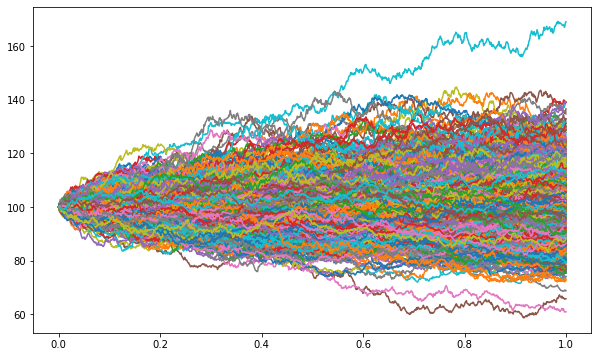

In [14]:
t=np.zeros((n_paths,n_steps))
for i in range(n_paths):
  t[i]=np.linspace(0,1,n_steps)


plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.plot(t[i], S[i, :], label=f'Path {i+1}')

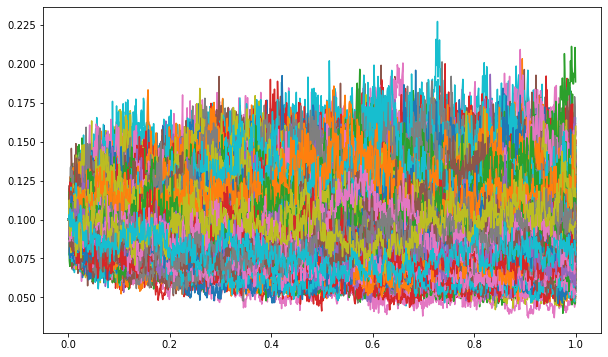

In [15]:
t=np.zeros((n_paths,n_steps))
for i in range(n_paths):
  t[i]=np.linspace(0,1,n_steps)


plt.figure(figsize=(10, 6))
for i in range(n_paths):
    plt.plot(t[i], sigma[i, :], label=f'Path {i+1}')


# Conditional Monte Carlo

In [16]:
def covariance(s, t, H):
    return 0.5 * (np.power(t, 2 * H) + np.power(s, 2 * H) - np.power(np.abs(t - s), 2 * H))

def BS(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

S0 = 100
sigma0 = 0.2
n_simulations = 50
n_paths = 1000
n_steps = 1000
dt = 1 / n_steps
T = 1
H = 0.2
t_i = np.linspace(0, T, n_steps)
nu = 0.4
r = 0.0

cov_matrix = np.zeros((n_steps - 1, n_steps - 1))
for i in range(n_steps - 1):
    for j in range(i + 1):
        cov_matrix[i, j] = covariance(t_i[i + 1], t_i[j + 1], H)
        cov_matrix[j, i] = cov_matrix[i, j]

lower_diag = np.linalg.cholesky(cov_matrix)

sqrt_2H = np.sqrt(2 * H)
nu_sq = nu**2

option_prices = []

def cond_MC_fBM(S0, K, sigma0, n_simulations, n_paths, T, H, nu, r, rho):
    option_prices = []
    
    start=time.time()

    for sim in range(n_simulations):
        W1 = np.random.normal(0, 1, size=(n_paths, n_steps - 1))
        W2 = np.random.normal(0, 1, size=(n_paths, n_steps - 1))

        paths = np.dot(W1, lower_diag.T)

        X = np.zeros((n_paths, n_steps))
        sigma = np.zeros((n_paths, n_steps))
        sigma[:, 0] = sigma0

        for j in range(n_steps - 1):
            sigma[:, j + 1] = sigma0 * np.exp(nu * sqrt_2H * paths[:, j] - 0.5 * (nu_sq * (t_i[j]**(2 * H))))

        integrated_volatility = np.sum(sigma[:, :-1]**2, axis=1) * dt

        rms_volatility = np.sqrt(np.mean(sigma[:, :-1]**2, axis=1))

        S = np.zeros((n_paths, n_steps))
        for i in range(n_paths):
            int_dw = np.sum(sigma[i, :-1] * W2[i], axis=0) * np.sqrt(dt)
            S0_prime = S0 * np.exp(-0.5 *rho**2* integrated_volatility[i] + int_dw*rho)
            sigdef = np.sqrt(1 - (rho**2)) * rms_volatility[i]
            W2_interpolated = np.interp(t_i, t_i[:-1], W2[i])  # Interpolate W2 to match the length of t_i
            S[i, :] = S0_prime * np.exp(-0.5 * (sigdef**2) * t_i + sigdef * W2_interpolated)

        
        final_prices = S[:, -1]
        payoffs = np.maximum(final_prices - K, 0)
        option_price = np.mean(payoffs) * np.exp(-r * T)
        option_prices.append(option_price)
        
    end=time.time()
    average_option_price = np.mean(option_prices)
    std_option_price = np.std(option_prices)
    duration=end-start
    return average_option_price, std_option_price, duration

In [17]:
S0 = 100
sigma0 = 0.1
n_simulations = 50
n_paths = 1000
n_steps = 1000
dt = 1 / n_steps
T = 1
H = 0.15
t_i = np.linspace(0, T, n_steps)
nu = 0.4
r = 0.0
K=80
rho=0.0

cond_MC_fBM(S0, K, sigma0, n_simulations, n_paths, T, H, nu, r, rho)

(19.954683439484114, 0.32388232978295817, 6.63691782951355)

# Implied Volatilities and Brent's method

In [24]:
def covariance(s, t, H):
    return 0.5 * (np.power(t, 2 * H) + np.power(s, 2 * H) - np.power(np.abs(t - s), 2 * H))

def BS(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

S0 = 100
sigma0 = 0.05
n_simulations = 100
n_paths = 100
n_steps = 1000
dt = 1 / n_steps
T = 1
H = 0.2
t_i = np.linspace(0, T, n_steps)
nu = 0.4
r = 0.0

cov_matrix = np.zeros((n_steps - 1, n_steps - 1))
for i in range(n_steps - 1):
    for j in range(i + 1):
        cov_matrix[i, j] = covariance(t_i[i + 1], t_i[j + 1], H)
        cov_matrix[j, i] = cov_matrix[i, j]
        
lower_diag = np.linalg.cholesky(cov_matrix)

sqrt_2H = np.sqrt(2 * H)
nu_sq = nu**2

option_prices = []

def cond_MC_fBM(S0, K, sigma0, n_simulations, n_paths, T, H, nu, r, rho):
    X_0 = np.log(S0)
    option_prices = []

    for sim in range(n_simulations):
        W1 = np.random.normal(0, 1, size=(n_paths, n_steps - 1))
        W2 = np.random.normal(0, 1, size=(n_paths, n_steps - 1))

        paths = np.dot(W1, lower_diag.T)

        X = np.zeros((n_paths, n_steps))
        sigma = np.zeros((n_paths, n_steps))
        X[:, 0] = X_0
        sigma[:, 0] = sigma0

        for j in range(n_steps - 1):
            sigma[:, j + 1] = sigma0 * np.exp(nu * sqrt_2H * paths[:, j] - 0.5 * (nu_sq * (t_i[j]**(2 * H))))

        integrated_volatility = np.sum(sigma[:, :-1]**2, axis=1) * dt

        rms_volatility = np.sqrt(np.mean(sigma[:, :-1]**2, axis=1))

        S = np.zeros((n_paths, n_steps))
        for i in range(n_paths):
            int_dw = np.sum(sigma[i, :-1] * W2[i], axis=0) * np.sqrt(dt)
            S0_prime = S0 * np.exp(-0.5 *rho**2* integrated_volatility[i] + int_dw*rho)
            sigdef = np.sqrt(1 - (rho**2)) * rms_volatility[i]
            W2_interpolated = np.interp(t_i, t_i[:-1], W2[i])  # Interpolate W2 to match the length of t_i
            S[i, :] = S0_prime * np.exp(-0.5 * (sigdef**2) * t_i + sigdef * W2_interpolated)

        final_prices = S[:, -1]
        payoffs = np.maximum(final_prices - K, 0)
        option_price = np.mean(payoffs) * np.exp(-r * T)
        option_prices.append(option_price)

    average_option_price = np.mean(option_prices)
    std_option_price = np.std(option_prices)
    return average_option_price#, std_option_price

def implied_vol(T,K,H):
  option_price=cond_MC_fBM(100, K, 0.05, 300, 300, T, H, 0.8, 0.0, 0.0)
  def error(a):
    return (BS(100,K,0.0,a,T)-option_price)**2
  return (optimize.brent(error, brack=(0.001,5)))

In [29]:
strike=np.zeros(7)
iv_01_01=np.zeros(7)
iv_01_06=np.zeros(7)
iv_01_09=np.zeros(7)
for j in range(0,7):
  strike[j]=85+5*j
  iv_01_01[j]=implied_vol(0.1,strike[j],0.15)

for j in range(0,7):
  iv_01_06[j]=implied_vol(0.1,strike[j],0.5)

for j in range(0,7):
  iv_01_09[j]=implied_vol(0.1,strike[j],0.85)

In [ ]:
df_t1 = pd.DataFrame({
    'Strike': [85,90,95,100,105,110,115],
    'H=0.15': iv_01_01,
    'H=0.5': iv_01_06,
    'H=0.85': iv_01_09
})

plt.figure(figsize=(10, 6))
plt.plot(df_t1['Strike'], df_t1['H=0.15'], label='H=0.15', color='r')
plt.plot(df_t1['Strike'], df_t1['H=0.5'], label='H=0.5', color='b')
plt.plot(df_t1['Strike'], df_t1['H=0.85'], label='H=0.85', color='black')

plt.title('Volatility Smile for T=0.1')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()

plt.show()

In [27]:
strike=np.zeros(7)
iv_2_01=np.zeros(7)
iv_2_06=np.zeros(7)
iv_2_09=np.zeros(7)
for j in range(0,7):
  strike[j]=85+5*j
  iv_2_01[j]=implied_vol(2,strike[j],0.15)

for j in range(0,7):
  iv_2_06[j]=implied_vol(2,strike[j],0.5)

for j in range(0,7):
  iv_2_09[j]=implied_vol(2,strike[j],0.85)

In [ ]:
df_t2 = pd.DataFrame({
    'Strike': [85,90,95,100,105,110,115],
    'H=0.15': iv_2_01,
    'H=0.5': iv_2_06,
    'H=0.85': iv_2_09
})

plt.figure(figsize=(10, 6))
plt.plot(df_t2['Strike'], df_t2['H=0.15'], label='H=0.15', color='r')
plt.plot(df_t2['Strike'], df_t2['H=0.5'], label='H=0.5', color='b')
plt.plot(df_t2['Strike'], df_t2['H=0.85'], label='H=0.85', color='black')

plt.title('Volatility Smile for T=2')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()

plt.show()